# Model Optimization


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
import warnings
warnings.filterwarnings('ignore')

In [3]:
kz_data = pd.read_csv('/Users/kassi/Data Mining/Final/Code/data/model_ready/kz_modeling_ready.csv')
foreign_data = pd.read_csv('/Users/kassi/Data Mining/Final/Code/data/model_ready/foreign_modeling_ready.csv')

In [4]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
def prepare_train_test_kz(df, test_size=0.2, random_state=42):
    """Split, encode categorical features, handle NaN, and scale (Kazakhstan)"""
    
    df = df.copy()
    
    # Target
    y = df['gpa']
    X = df.drop(columns=['gpa'])
    
    # Encode categorical + fill NaN
    for col in X.columns:
        if X[col].dtype == 'object' or str(X[col].dtype) == 'category':
            X[col] = X[col].astype(str).fillna('missing')
            le = LabelEncoder()
            X[col] = le.fit_transform(X[col])
        else:
            X[col] = X[col].fillna(X[col].mean())
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    
    # Scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, X_test_scaled, y_train, y_test, scaler

def prepare_train_test_foreign(df, test_size=0.2, random_state=42):
    """Split, encode categorical features, handle NaN, and scale (Foreign)"""
    
    df = df.copy()
    
    y = df['final_grade']
    X = df.drop(columns=['final_grade'])
    
    for col in X.columns:
        if X[col].dtype == 'object' or str(X[col].dtype) == 'category':
            X[col] = X[col].astype(str).fillna('missing')
            le = LabelEncoder()
            X[col] = le.fit_transform(X[col])
        else:
            X[col] = X[col].fillna(X[col].mean())
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, X_test_scaled, y_train, y_test, scaler

kz_X_train, kz_X_test, kz_y_train, kz_y_test, kz_scaler = \
    prepare_train_test_kz(kz_data)

foreign_X_train, foreign_X_test, foreign_y_train, foreign_y_test, foreign_scaler = \
    prepare_train_test_foreign(foreign_data)

print("\nTrain/Test Split Complete!")
print(f"Kazakhstan - Train: {kz_X_train.shape}, Test: {kz_X_test.shape}")
print(f"Foreign - Train: {foreign_X_train.shape}, Test: {foreign_X_test.shape}")


Train/Test Split Complete!
Kazakhstan - Train: (96, 15), Test: (25, 15)
Foreign - Train: (519, 15), Test: (130, 15)


# Random Forest - Grid Search

In [5]:
print("\n" + "="*60)
print("RANDOM FOREST - GRID SEARCH OPTIMIZATION")
print("="*60)

# Define parameter grid
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

print("\nParameter grid:")
for param, values in rf_param_grid.items():
    print(f"  {param}: {values}")


RANDOM FOREST - GRID SEARCH OPTIMIZATION

Parameter grid:
  n_estimators: [50, 100, 200]
  max_depth: [10, 20, 30, None]
  min_samples_split: [2, 5, 10]
  min_samples_leaf: [1, 2, 4]
  max_features: ['sqrt', 'log2']


In [8]:
# Kazakhstan - Random Forest Grid Search
print("\n--- Kazakhstan: Random Forest Grid Search ---")

rf_grid_kz = GridSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1),
    rf_param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

rf_grid_kz.fit(kz_X_train, kz_y_train)

print(f"\nBest parameters: {rf_grid_kz.best_params_}")
print(f"Best CV R² score: {rf_grid_kz.best_score_:.4f}")


--- Kazakhstan: Random Forest Grid Search ---
Fitting 5 folds for each of 216 candidates, totalling 1080 fits

Best parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best CV R² score: -0.0827


In [9]:
# Evaluate on test set
kz_rf_best = rf_grid_kz.best_estimator_
kz_rf_pred = kz_rf_best.predict(kz_X_test)
kz_rf_r2 = r2_score(kz_y_test, kz_rf_pred)
kz_rf_rmse = np.sqrt(mean_squared_error(kz_y_test, kz_rf_pred))

print(f"Test R²: {kz_rf_r2:.4f}")
print(f"Test RMSE: {kz_rf_rmse:.4f}")

Test R²: 0.1659
Test RMSE: 0.7647


In [10]:
# Foreign - Random Forest Grid Search
print("\n--- Foreign: Random Forest Grid Search ---")

rf_grid_foreign = GridSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1),
    rf_param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

rf_grid_foreign.fit(foreign_X_train, foreign_y_train)

print(f"\nBest parameters: {rf_grid_foreign.best_params_}")
print(f"Best CV R² score: {rf_grid_foreign.best_score_:.4f}")

# Evaluate
foreign_rf_best = rf_grid_foreign.best_estimator_
foreign_rf_pred = foreign_rf_best.predict(foreign_X_test)
foreign_rf_r2 = r2_score(foreign_y_test, foreign_rf_pred)
foreign_rf_rmse = np.sqrt(mean_squared_error(foreign_y_test, foreign_rf_pred))

print(f"Test R²: {foreign_rf_r2:.4f}")
print(f"Test RMSE: {foreign_rf_rmse:.4f}")


--- Foreign: Random Forest Grid Search ---
Fitting 5 folds for each of 216 candidates, totalling 1080 fits

Best parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best CV R² score: 0.8703
Test R²: 0.8916
Test RMSE: 0.3866


# Gradient Boosting - Grid Search

In [11]:
print("\n" + "="*60)
print("GRADIENT BOOSTING - GRID SEARCH OPTIMIZATION")
print("="*60)

# Define parameter grid
gb_param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.8, 0.9, 1.0]
}

print("\nParameter grid:")
for param, values in gb_param_grid.items():
    print(f"  {param}: {values}")


GRADIENT BOOSTING - GRID SEARCH OPTIMIZATION

Parameter grid:
  n_estimators: [50, 100, 200]
  learning_rate: [0.01, 0.05, 0.1]
  max_depth: [3, 5, 7]
  min_samples_split: [2, 5, 10]
  min_samples_leaf: [1, 2, 4]
  subsample: [0.8, 0.9, 1.0]


In [12]:
# Kazakhstan - GB Grid Search
print("\n--- Kazakhstan: Gradient Boosting Grid Search ---")

gb_grid_kz = GridSearchCV(
    GradientBoostingRegressor(random_state=42),
    gb_param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

gb_grid_kz.fit(kz_X_train, kz_y_train)

print(f"\nBest parameters: {gb_grid_kz.best_params_}")
print(f"Best CV R² score: {gb_grid_kz.best_score_:.4f}")

# Evaluate
kz_gb_best = gb_grid_kz.best_estimator_
kz_gb_pred = kz_gb_best.predict(kz_X_test)
kz_gb_r2 = r2_score(kz_y_test, kz_gb_pred)
kz_gb_rmse = np.sqrt(mean_squared_error(kz_y_test, kz_gb_pred))

print(f"Test R²: {kz_gb_r2:.4f}")
print(f"Test RMSE: {kz_gb_rmse:.4f}")


--- Kazakhstan: Gradient Boosting Grid Search ---
Fitting 5 folds for each of 729 candidates, totalling 3645 fits

Best parameters: {'learning_rate': 0.01, 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 50, 'subsample': 0.8}
Best CV R² score: -0.0504
Test R²: 0.1256
Test RMSE: 0.7829


In [13]:
# Foreign - GB Grid Search
print("\n--- Foreign: Gradient Boosting Grid Search ---")

gb_grid_foreign = GridSearchCV(
    GradientBoostingRegressor(random_state=42),
    gb_param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

gb_grid_foreign.fit(foreign_X_train, foreign_y_train)

print(f"\nBest parameters: {gb_grid_foreign.best_params_}")
print(f"Best CV R² score: {gb_grid_foreign.best_score_:.4f}")

# Evaluate
foreign_gb_best = gb_grid_foreign.best_estimator_
foreign_gb_pred = foreign_gb_best.predict(foreign_X_test)
foreign_gb_r2 = r2_score(foreign_y_test, foreign_gb_pred)
foreign_gb_rmse = np.sqrt(mean_squared_error(foreign_y_test, foreign_gb_pred))

print(f"Test R²: {foreign_gb_r2:.4f}")
print(f"Test RMSE: {foreign_gb_rmse:.4f}")



--- Foreign: Gradient Boosting Grid Search ---
Fitting 5 folds for each of 729 candidates, totalling 3645 fits

Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'subsample': 1.0}
Best CV R² score: 0.8887
Test R²: 0.9058
Test RMSE: 0.3604


# Random Search for Faster Optimization

In [14]:
print("\n" + "="*60)
print("RANDOM FOREST - RANDOM SEARCH")
print("="*60)

from scipy.stats import randint, uniform

rf_param_distributions = {
    'n_estimators': randint(50, 300),
    'max_depth': [10, 20, 30, 40, 50, None],
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}



RANDOM FOREST - RANDOM SEARCH


In [15]:
# Kazakhstan - Random Search
print("\n--- Kazakhstan: Random Forest Random Search ---")

rf_random_kz = RandomizedSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1),
    rf_param_distributions,
    n_iter=50,  # Number of parameter settings sampled
    cv=5,
    scoring='r2',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

rf_random_kz.fit(kz_X_train, kz_y_train)

print(f"\nBest parameters: {rf_random_kz.best_params_}")
print(f"Best CV R² score: {rf_random_kz.best_score_:.4f}")

# Evaluate
kz_rf_random_pred = rf_random_kz.best_estimator_.predict(kz_X_test)
print(f"Test R²: {r2_score(kz_y_test, kz_rf_random_pred):.4f}")


--- Kazakhstan: Random Forest Random Search ---
Fitting 5 folds for each of 50 candidates, totalling 250 fits

Best parameters: {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 9, 'min_samples_split': 16, 'n_estimators': 64}
Best CV R² score: -0.0485
Test R²: 0.1040


# Compare Baseline vs Optimized Models

In [16]:
baseline_results = pd.read_csv('/Users/kassi/Data Mining/Final/Code/report/ensemble/all_models_comparison.csv')

In [17]:
# Create optimized results
optimized_results = pd.DataFrame([
    {
        'Model': 'Random Forest (Optimized)',
        'Dataset': 'Kazakhstan',
        'Test_R2': kz_rf_r2,
        'Test_RMSE': kz_rf_rmse
    },
    {
        'Model': 'Gradient Boosting (Optimized)',
        'Dataset': 'Kazakhstan',
        'Test_R2': kz_gb_r2,
        'Test_RMSE': kz_gb_rmse
    },
    {
        'Model': 'Random Forest (Optimized)',
        'Dataset': 'Foreign',
        'Test_R2': foreign_rf_r2,
        'Test_RMSE': foreign_rf_rmse
    },
    {
        'Model': 'Gradient Boosting (Optimized)',
        'Dataset': 'Foreign',
        'Test_R2': foreign_gb_r2,
        'Test_RMSE': foreign_gb_rmse
    }
])

print("\n" + "="*60)
print("BASELINE VS OPTIMIZED COMPARISON")
print("="*60)



BASELINE VS OPTIMIZED COMPARISON


In [18]:
# Kazakhstan comparison
print("\n--- Kazakhstan ---")
kz_baseline = baseline_results[baseline_results['Dataset'] == 'Kazakhstan']
kz_rf_baseline = kz_baseline[kz_baseline['Model'] == 'Random Forest'].iloc[0]
kz_gb_baseline = kz_baseline[kz_baseline['Model'] == 'Gradient Boosting'].iloc[0]

print("\nRandom Forest:")
print(f"  Baseline R²: {kz_rf_baseline['Test_R2']:.4f} → Optimized R²: {kz_rf_r2:.4f}")
print(f"  Improvement: {((kz_rf_r2 - kz_rf_baseline['Test_R2']) / kz_rf_baseline['Test_R2'] * 100):.2f}%")

print("\nGradient Boosting:")
print(f"  Baseline R²: {kz_gb_baseline['Test_R2']:.4f} → Optimized R²: {kz_gb_r2:.4f}")
print(f"  Improvement: {((kz_gb_r2 - kz_gb_baseline['Test_R2']) / kz_gb_baseline['Test_R2'] * 100):.2f}%")

# Foreign comparison
print("\n--- Foreign ---")
foreign_baseline = baseline_results[baseline_results['Dataset'] == 'Foreign']
foreign_rf_baseline = foreign_baseline[foreign_baseline['Model'] == 'Random Forest'].iloc[0]
foreign_gb_baseline = foreign_baseline[foreign_baseline['Model'] == 'Gradient Boosting'].iloc[0]

print("\nRandom Forest:")
print(f"  Baseline R²: {foreign_rf_baseline['Test_R2']:.4f} → Optimized R²: {foreign_rf_r2:.4f}")
print(f"  Improvement: {((foreign_rf_r2 - foreign_rf_baseline['Test_R2']) / foreign_rf_baseline['Test_R2'] * 100):.2f}%")

print("\nGradient Boosting:")
print(f"  Baseline R²: {foreign_gb_baseline['Test_R2']:.4f} → Optimized R²: {foreign_gb_r2:.4f}")
print(f"  Improvement: {((foreign_gb_r2 - foreign_gb_baseline['Test_R2']) / foreign_gb_baseline['Test_R2'] * 100):.2f}%")



--- Kazakhstan ---

Random Forest:
  Baseline R²: -0.0367 → Optimized R²: 0.1659
  Improvement: -552.18%

Gradient Boosting:
  Baseline R²: 0.1048 → Optimized R²: 0.1256
  Improvement: 19.86%

--- Foreign ---

Random Forest:
  Baseline R²: 0.9112 → Optimized R²: 0.8916
  Improvement: -2.15%

Gradient Boosting:
  Baseline R²: 0.9058 → Optimized R²: 0.9058
  Improvement: 0.00%


# Visualization: Baseline vs Optimized

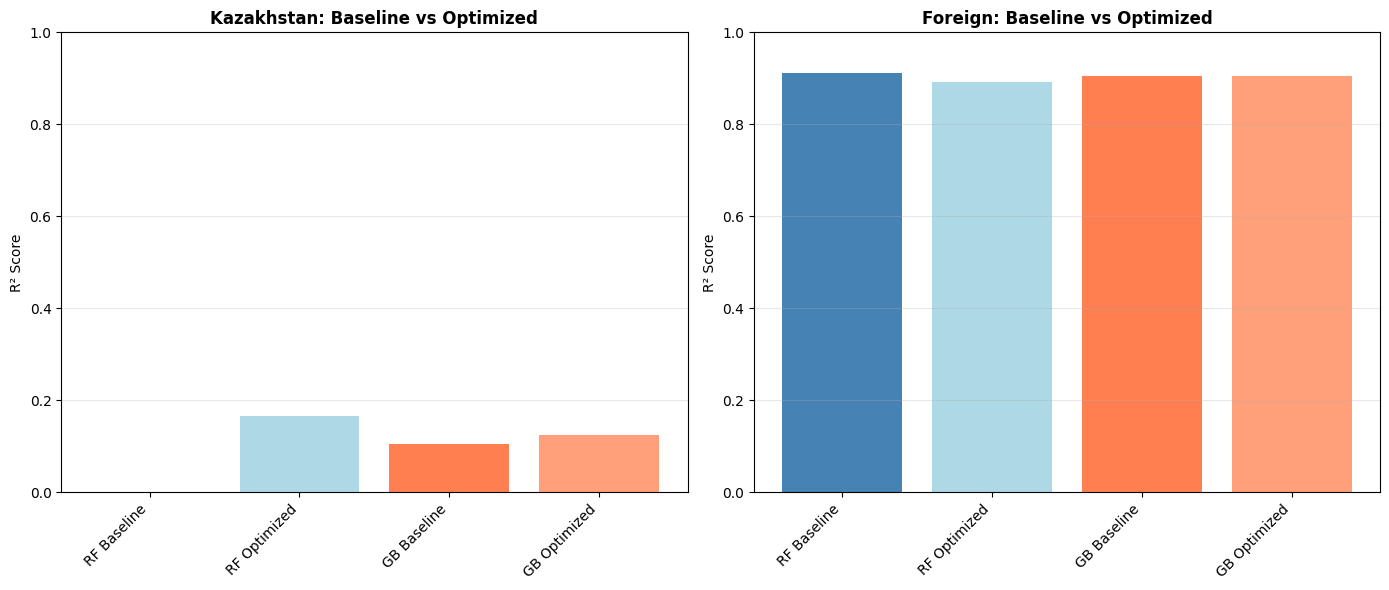

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Kazakhstan
kz_comparison = pd.DataFrame({
    'Model': ['RF Baseline', 'RF Optimized', 'GB Baseline', 'GB Optimized'],
    'R2_Score': [
        kz_rf_baseline['Test_R2'], kz_rf_r2,
        kz_gb_baseline['Test_R2'], kz_gb_r2
    ]
})

axes[0].bar(kz_comparison['Model'], kz_comparison['R2_Score'], 
           color=['steelblue', 'lightblue', 'coral', 'lightsalmon'])
axes[0].set_ylabel('R² Score')
axes[0].set_title('Kazakhstan: Baseline vs Optimized', fontweight='bold')
axes[0].set_ylim([0, 1])
axes[0].grid(axis='y', alpha=0.3)
plt.sca(axes[0])
plt.xticks(rotation=45, ha='right')

# Foreign
foreign_comparison = pd.DataFrame({
    'Model': ['RF Baseline', 'RF Optimized', 'GB Baseline', 'GB Optimized'],
    'R2_Score': [
        foreign_rf_baseline['Test_R2'], foreign_rf_r2,
        foreign_gb_baseline['Test_R2'], foreign_gb_r2
    ]
})

axes[1].bar(foreign_comparison['Model'], foreign_comparison['R2_Score'],
           color=['steelblue', 'lightblue', 'coral', 'lightsalmon'])
axes[1].set_ylabel('R² Score')
axes[1].set_title('Foreign: Baseline vs Optimized', fontweight='bold')
axes[1].set_ylim([0, 1])
axes[1].grid(axis='y', alpha=0.3)
plt.sca(axes[1])
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.savefig('../results/figures/baseline_vs_optimized.png', dpi=300, bbox_inches='tight')
plt.show()

# Learning Curves

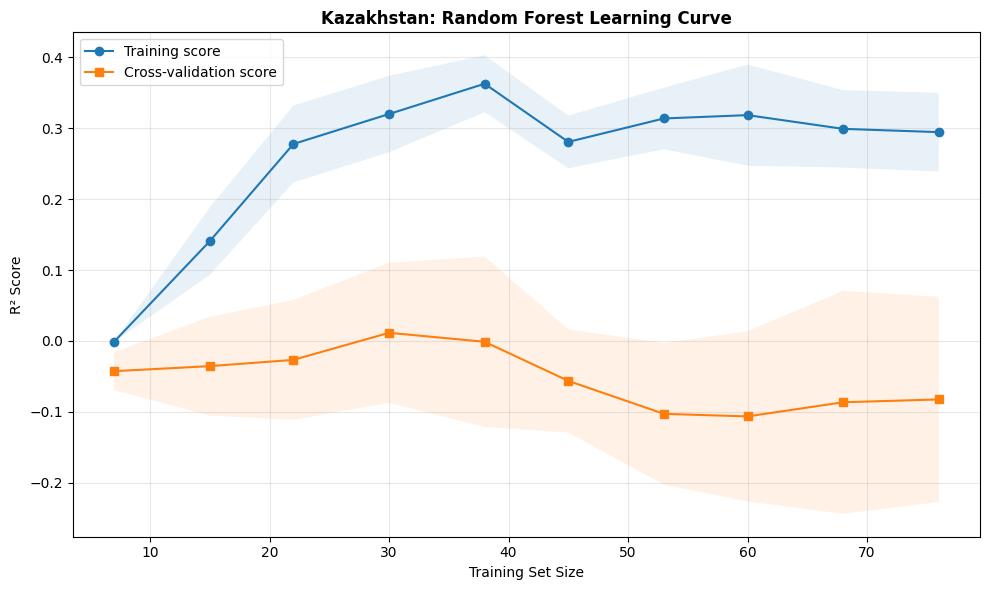

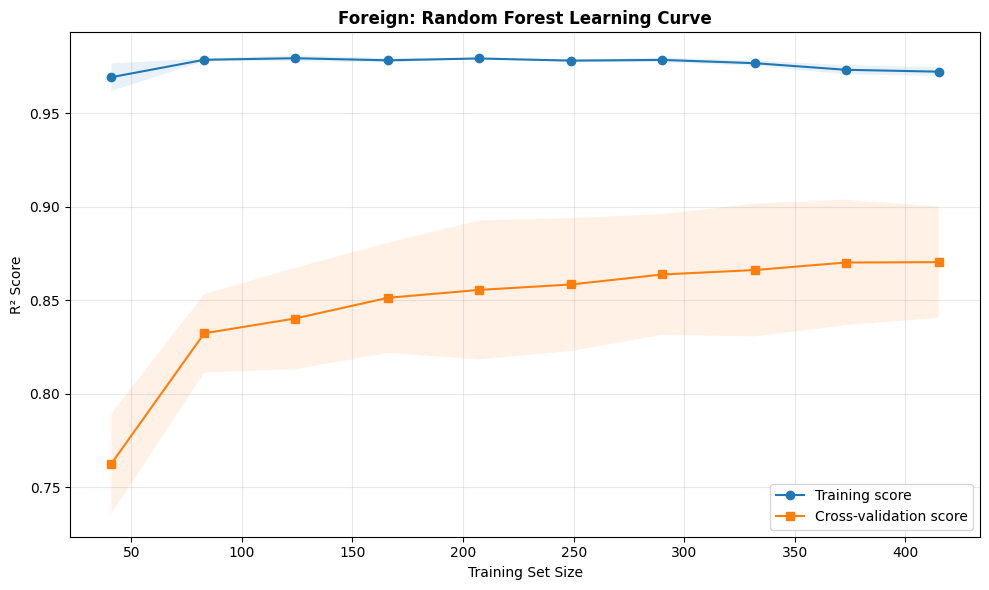

In [21]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, X, y, title):
    """Plot learning curve"""
    train_sizes, train_scores, val_scores = learning_curve(
        estimator, X, y, cv=5, n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10),
        scoring='r2'
    )
    
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, label='Training score', marker='o')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
    
    plt.plot(train_sizes, val_mean, label='Cross-validation score', marker='s')
    plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1)
    
    plt.xlabel('Training Set Size')
    plt.ylabel('R² Score')
    plt.title(title, fontweight='bold')
    plt.legend(loc='best')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

# Kazakhstan RF
plot_learning_curve(kz_rf_best, kz_X_train, kz_y_train, 
                   'Kazakhstan: Random Forest Learning Curve')
plt.savefig('/Users/kassi/Data Mining/Final/Code/figure/model_optimization/kz_rf_learning_curve.png', dpi=300, bbox_inches='tight')
plt.show()

# Foreign RF
plot_learning_curve(foreign_rf_best, foreign_X_train, foreign_y_train,
                   'Foreign: Random Forest Learning Curve')
plt.savefig('/Users/kassi/Data Mining/Final/Code/figure/model_optimization/foreign_rf_learning_curve.png', dpi=300, bbox_inches='tight')
plt.show()

# Final Model Selection

In [22]:
print("\n" + "="*60)
print("FINAL MODEL SELECTION")
print("="*60)

# Determine best optimized models
kz_best_r2 = max(kz_rf_r2, kz_gb_r2)
kz_best_model_name = "Random Forest" if kz_rf_r2 >= kz_gb_r2 else "Gradient Boosting"
kz_best_model = kz_rf_best if kz_rf_r2 >= kz_gb_r2 else kz_gb_best

foreign_best_r2 = max(foreign_rf_r2, foreign_gb_r2)
foreign_best_model_name = "Random Forest" if foreign_rf_r2 >= foreign_gb_r2 else "Gradient Boosting"
foreign_best_model = foreign_rf_best if foreign_rf_r2 >= foreign_gb_r2 else foreign_gb_best

print(f"\nKazakhstan Best Model: {kz_best_model_name} (Optimized)")
print(f"  Test R²: {kz_best_r2:.4f}")

print(f"\nForeign Best Model: {foreign_best_model_name} (Optimized)")
print(f"  Test R²: {foreign_best_r2:.4f}")



FINAL MODEL SELECTION

Kazakhstan Best Model: Random Forest (Optimized)
  Test R²: 0.1659

Foreign Best Model: Gradient Boosting (Optimized)
  Test R²: 0.9058


# Save Optimized Models

In [24]:
import pickle

# Save models
with open('/Users/kassi/Data Mining/Final/Code/models/model_optimization/kz_best_model.pkl', 'wb') as f:
    pickle.dump(kz_best_model, f)

with open('/Users/kassi/Data Mining/Final/Code/models/model_optimization/foreign_best_model.pkl', 'wb') as f:
    pickle.dump(foreign_best_model, f)

print("\nOptimized models saved!")

# Save optimization results
optimized_results.to_csv('/Users/kassi/Data Mining/Final/Code/report/model_optimization/optimized_models_results.csv', index=False)

# Save best hyperparameters
hyperparams_df = pd.DataFrame([
    {
        'Dataset': 'Kazakhstan',
        'Model': kz_best_model_name,
        'Best_Params': str(rf_grid_kz.best_params_ if kz_best_model_name == "Random Forest" else gb_grid_kz.best_params_)
    },
    {
        'Dataset': 'Foreign',
        'Model': foreign_best_model_name,
        'Best_Params': str(rf_grid_foreign.best_params_ if foreign_best_model_name == "Random Forest" else gb_grid_foreign.best_params_)
    }
])

hyperparams_df.to_csv('/Users/kassi/Data Mining/Final/Code/report/model_optimization/best_hyperparameters.csv', index=False)

print("Optimization results saved!")


Optimized models saved!
Optimization results saved!
